In [1]:
#Imports
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Exploring
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# default pandas decimal number display format
pd.options.display.float_format = '{:20,.2f}'.format

import acquire
import summarize
import prepare

### Wrangle Data

In [2]:
df = acquire.get_mall_data()
df.head()

this file exists, reading from csv


,Gender,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


In [3]:
df['is_male'] = pd.get_dummies(df['Gender'], drop_first=True)['Male']
df.drop(columns=['Gender'], inplace=True)
df.head()

,Age,Annual Income (k$),Spending Score (1-100),is_male
CustomerID,,,,
1,19,15,39,True
2,21,15,81,True
3,20,16,6,False
4,23,16,77,False
5,31,17,40,False


In [4]:
df = df.rename(columns={'Spending Score (1-100)':'spending_score', 'Annual Income (k$)':'annual_income'})

In [5]:
#Function to split the data
def split_data(df):
    """
    Recieves dataframe as 'df' and target variable to stratify as 'col'
    First split does a 60% train and 40% validate
    Second split uses the 40% validate to make 50% validate and 50% test
    """
    #first split
    train, validate_test = train_test_split(df, #send in initial df
                train_size = 0.60, #size of the train df, and the test size will default to 1-train_size
                random_state = 123, #set any number here for consistency
                )
    
    #second split
    validate, test = train_test_split(validate_test, #we are spliting the 40% df we just made
                test_size = 0.50, #split 50/50
                random_state = 123, #gotta send in a random seed
                )
    print(f'''
Train Shape: {train.shape}
Validate Shape: {validate.shape}
Test Shape: {test.shape}
    ''')
    return train, validate, test

In [6]:
#Get the split data
train, validate, test = split_data(df)


Train Shape: (120, 4)
Validate Shape: (40, 4)
Test Shape: (40, 4)
    


### Explore

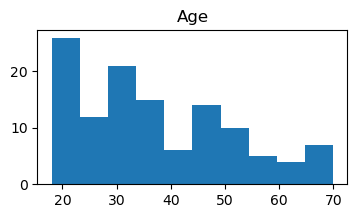

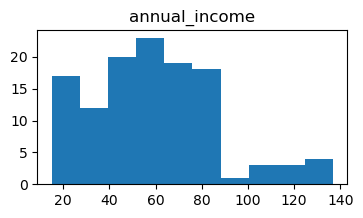

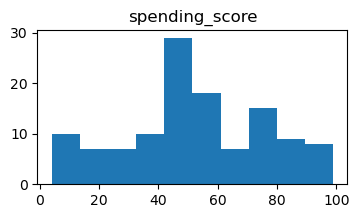

In [7]:
#What are the distributions for each column?
for col in train.drop(columns='is_male').columns:
    plt.figure(figsize=(4,2))
    plt.hist(train[col])
    plt.title(col)
    plt.show()

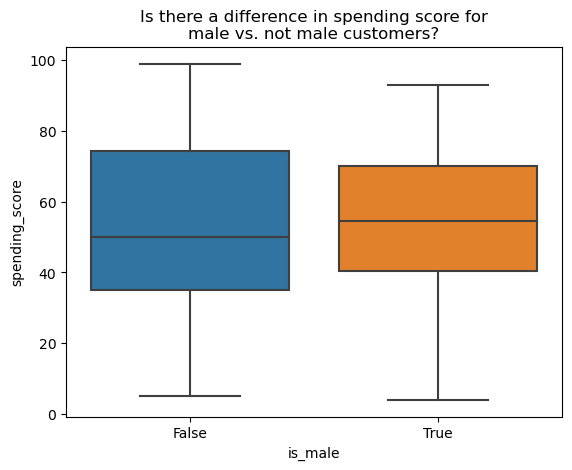

In [8]:
#Does spending score differ across gender?
sns.boxplot(x=train.is_male, y=train.spending_score)
plt.title("Is there a difference in spending score for\nmale vs. not male customers?")
plt.show()

Null Hypothesis (They're equal) using Levene's Test

In [10]:
stats.levene(train[train.is_male==0].spending_score, 
             train[train.is_male==1].spending_score)

LeveneResult(statistic=0.03387345525305705, pvalue=0.8542921592973909)

In [11]:
stats.ttest_ind(train[train.is_male==0].spending_score, 
                train[train.is_male==1].spending_score, 
                equal_var=True)

Ttest_indResult(statistic=-0.08252554346863719, pvalue=0.9343686328908001)

There is not a difference in mean

Is there a relationship between annual income and spending score?


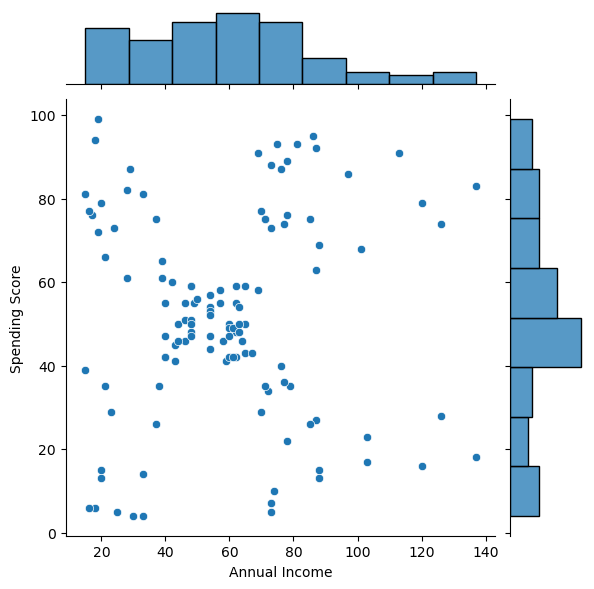

In [18]:
#Is there a relationship between spending score and annual income?
sns.jointplot(x="annual_income", y="spending_score", data=train)
print("Is there a relationship between annual income and spending score?")
plt.xlabel("Annual Income")
plt.ylabel("Spending Score")
plt.show()

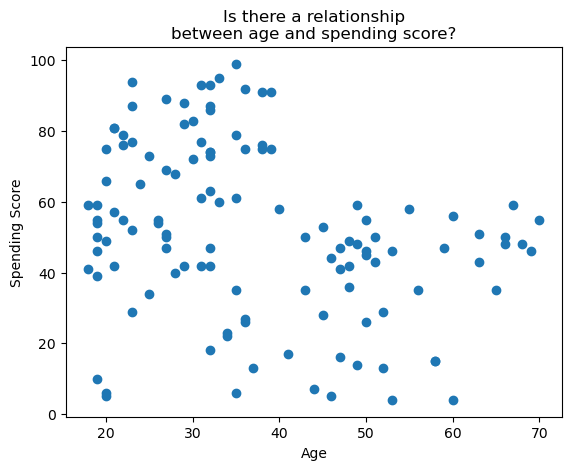

In [20]:
#Is there a relationship between age and spending score?
plt.scatter(train.Age, train.spending_score)
plt.xlabel("Age")
plt.ylabel("Spending Score")
plt.title("Is there a relationship\nbetween age and spending score?")
plt.show()

In [22]:
#Create a bin for 0 - 40 and 40 - 80
#This is because after 40 there is a significant drop off in spending score
train['age_bin'] = pd.cut(train.Age, [0,40, 80])
train.head()

,Age,annual_income,spending_score,is_male,age_bin
CustomerID,,,,,
8,23,18,94,False,"(0, 40]"
31,60,30,4,True,"(40, 80]"
178,27,88,69,True,"(0, 40]"
133,25,72,34,False,"(0, 40]"
30,23,29,87,False,"(0, 40]"


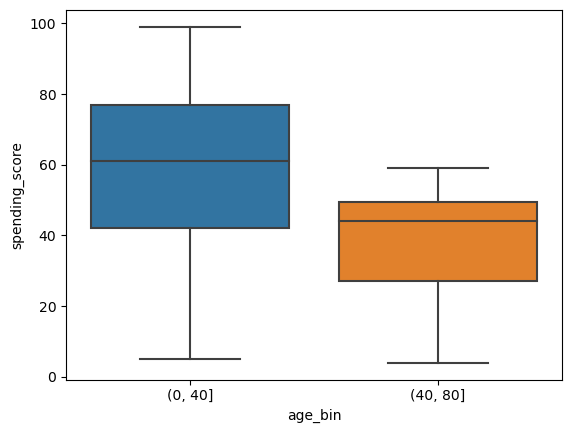

In [23]:
#Box plot of the age bins and their spending score
sns.boxplot(x=train.age_bin, y=train.spending_score)
plt.show()

In [25]:
stats.levene(train[train.Age <= 40].spending_score, 
             train[train.Age > 40].spending_score)

LeveneResult(statistic=7.358228530924334, pvalue=0.007674535828760927)

Variances are unequal, p-value < 0.05

In [27]:
stats.ttest_ind(train[train.Age <= 40].spending_score, 
                train[train.Age > 40].spending_score,
                equal_var=False)

Ttest_indResult(statistic=5.880176757769305, pvalue=4.2743604622995745e-08)

There is no linear relationship and there is a significant difference in spending score between ages

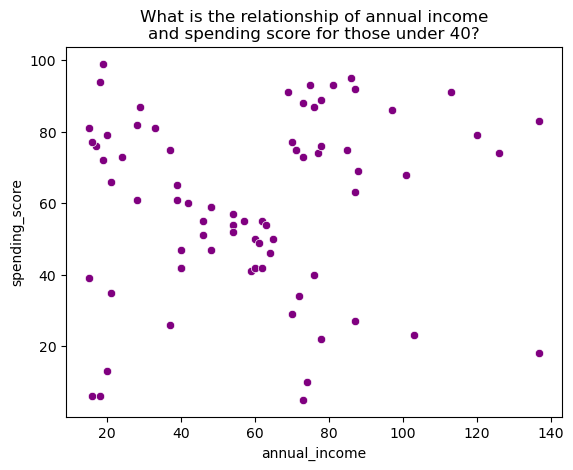

In [41]:
#Does spending score differe across annual income when age is controlled? (Under 40)
sns.scatterplot(x='annual_income', y='spending_score', 
                data=train[train.Age < 40], 
                color='purple')
plt.title("What is the relationship of annual income\nand spending score for those under 40?")
plt.show()

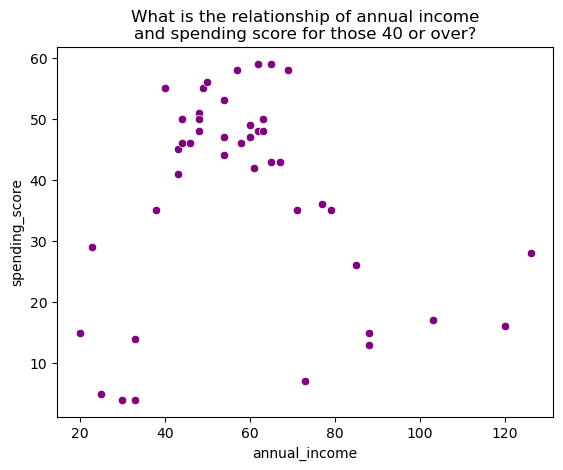

In [42]:
#Does spending score differe across annual income when age is controlled? (40 or over)
sns.scatterplot(x='annual_income', y='spending_score', 
                data=train[train.Age >= 40], 
                color='purple')
plt.title("What is the relationship of annual income\nand spending score for those 40 or over?")
plt.show()

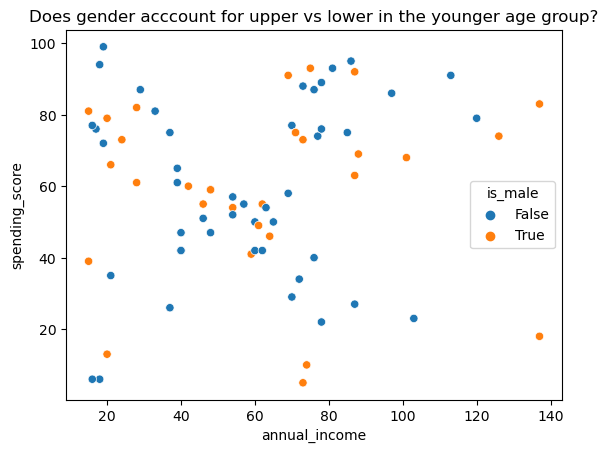

In [44]:
#Does gender explain the high income and low spending in ages under 40?
sns.scatterplot(x='annual_income', y='spending_score',
               data=train[train.Age <= 40], hue='is_male')

plt.title("Does gender acccount for upper vs lower in the younger age group?")
plt.show()

In [45]:
#If we control for income, does spending score differ across age?
#Bin income into 3 bins
train['income_bin'] = pd.cut(train.annual_income, [0, 40, 70, 140])

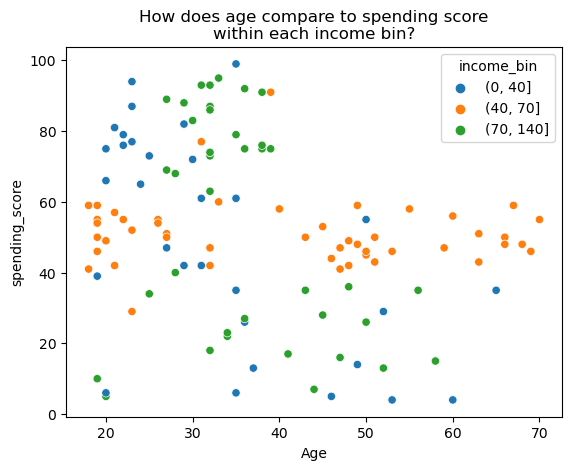

In [46]:
sns.scatterplot(x='Age', y='spending_score',
               data=train, hue='income_bin')
plt.title("How does age compare to spending score\nwithin each income bin?")
plt.show()

Interaction of variables along with income bins


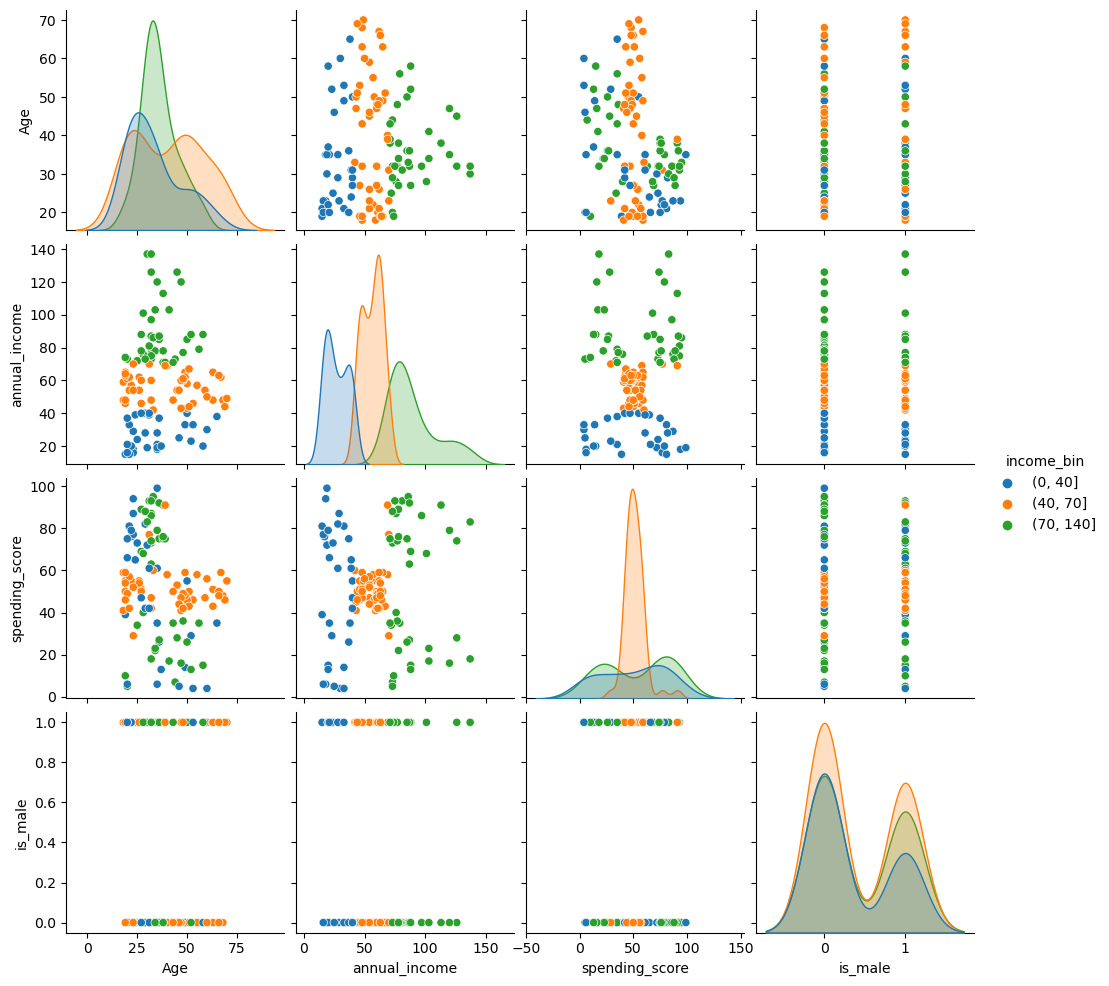

In [47]:
print("Interaction of variables along with income bins")
sns.pairplot(train, hue='income_bin')
plt.show()

Interaction of variables along with gender


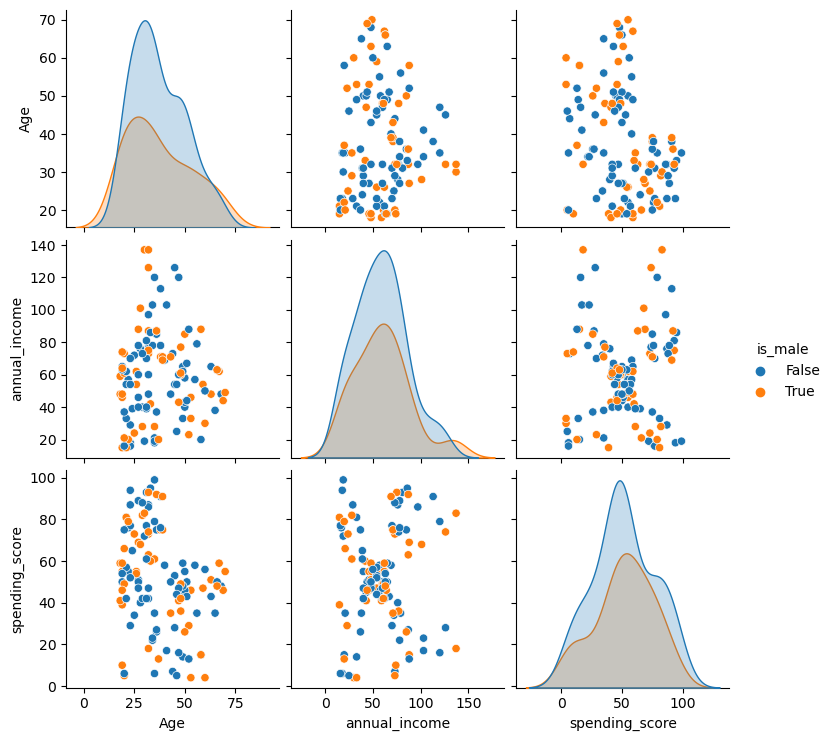

In [48]:
print("Interaction of variables along with gender")
sns.pairplot(train, hue='is_male')
plt.show()

<Axes: xlabel='is_male'>

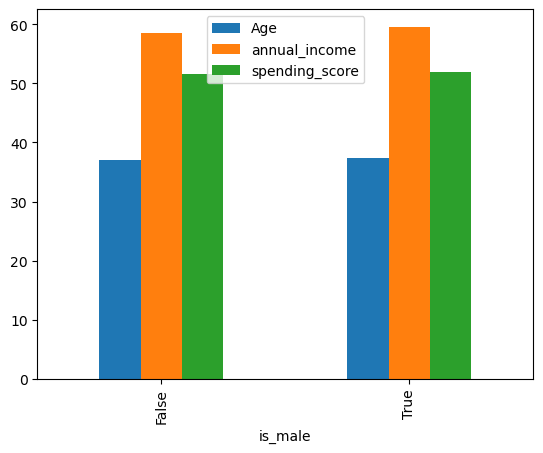

In [49]:
train.drop(columns=['age_bin', 'income_bin']).groupby('is_male').mean().plot.bar()